# Dataset information analysis

## Imports and Environment

In [1]:
import numpy as np
import faiss
import sys
import os

from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

dataset_confs = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "color": "lightblue",
            "marker": "o",
        },
        "DEEP100M": {
            "M": 32,
            "efC": 500,
            "efS": 750,
            "color": "plum",
            "marker": "x",   
        },
        "T2I100M": {
            "M": 48,
            "efC": 500,
            "efS": 1000,
            "color": "rosybrown",
            "marker": "d",
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "color": "orange",
            "marker": "^",
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "color": "lightgreen",
            "marker": "s",
        },
    }
def read_fvecs(file_path, limit=None):
    vectors = None
    dim = None
    with open(file_path, 'rb') as f:
        first_entry = np.fromfile(f, dtype=np.int32, count=1)
        if len(first_entry) == 0:
            raise ValueError("The file is empty or not in the expected fvecs format.")
        dim = first_entry[0]

        f.seek(0)
        vector_size = (dim + 1) * 4

        f.seek(0, 2)
        file_size = f.tell()
        f.seek(0)

        num_vectors = file_size // vector_size

        if limit is not None and limit < num_vectors:
            num_vectors = limit

        data = np.fromfile(f, dtype=np.float32, count=num_vectors * (dim + 1))
        data = data.reshape(-1, dim + 1)

        vectors = data[:, 1:]

        assert vectors.shape == (num_vectors, dim)

    return vectors, int(dim)

DIRECTORY_TO_SAVE = "/data/mchatzakis/datasets/processed"

dataset_params = {
    "SIFT100M": {
        "M": 32,
        "efC": 500,
        "efS": 500,
        "queries_path": f"{DIRECTORY_TO_SAVE}/SIFT100M/query.10K.fvecs",
        "queries_gt_distances_path": f"{DIRECTORY_TO_SAVE}/SIFT100M/query.groundtruth.10K.k1000.fvecs",
        "base_path": f"{DIRECTORY_TO_SAVE}/SIFT100M/base.100M.fvecs",
    },
    "GIST1M": {
        "M": 32,
        "efC": 500,
        "efS": 1000,
        "queries_path": f"{DIRECTORY_TO_SAVE}/GIST1M/query.1K.fvecs",
        "queries_gt_distances_path": f"{DIRECTORY_TO_SAVE}/GIST1M/query.groundtruth.1K.k1000.fvecs",
        "base_path": f"{DIRECTORY_TO_SAVE}/GIST1M/base.1M.fvecs",
    },
    "GLOVE100": {
        "M": 16,
        "efC": 500,
        "efS": 500,
        "queries_path": f"{DIRECTORY_TO_SAVE}/GLOVE100/query.10K.fvecs",
        "queries_gt_distances_path": f"{DIRECTORY_TO_SAVE}/GLOVE100/query.groundtruth.10K.k1000.fvecs",
        "base_path": f"{DIRECTORY_TO_SAVE}/GLOVE100/base.1183514.fvecs",
    },
    "DEEP100M":{
        "M": 32,
        "efC": 500,
        "efS": 750,
        "queries_path": f"{DIRECTORY_TO_SAVE}/DEEP100M/query.10K.fvecs",
        "queries_gt_distances_path": f"{DIRECTORY_TO_SAVE}/DEEP100M/query.groundtruth.10K.k1000.fvecs",
        "base_path": f"{DIRECTORY_TO_SAVE}/DEEP100M/base.100M.fvecs",
    },
    "T2I100M":{
        "M": 64,
        "efC": 500,
        "efS": 750,
        "queries_path": f"{DIRECTORY_TO_SAVE}/T2I100M/query.10K.fvecs",
        "queries_gt_distances_path": f"{DIRECTORY_TO_SAVE}/T2I100M/query.groundtruth.10K.k1000.fvecs",
        "base_path": f"{DIRECTORY_TO_SAVE}/T2I100M/base.100M.fvecs",
    }
}

## Local Intrinsic Dimensionality (LID)

In [4]:
def compute_lid_from_dists(all_query_distances, all_k, k, num_queries, epsilon=1e-1):
    lids = []
    for i in range(num_queries):
        sorted_distances = np.sort(all_query_distances[i])[0:k]  
        
        r_k = sorted_distances[-1]
        
        # If r_k is zero (exact match), set LID to a special value or skip
        if r_k == 0:
            #lids.append(np.inf)  # or np.nan, depending on how you want to handle this case
            continue
        else:
            # Safely compute LID, ensuring no log(0) or negative values
            safe_distances = np.maximum(sorted_distances / r_k, epsilon)  # Ensure the ratio is > 0
            log_values = np.log(safe_distances)
            lid = -1 / (np.mean(log_values))
            
            if np.isnan(lid) or np.isinf(lid):
                continue
            
            lids.append(lid)
    
    return np.array(lids)

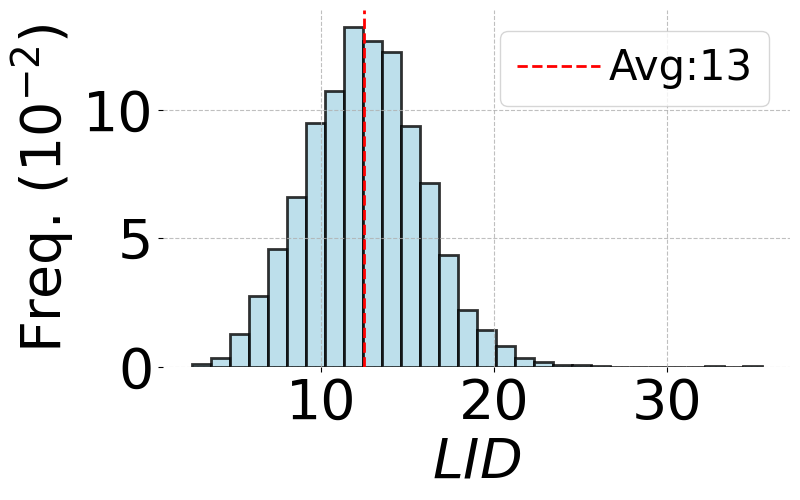

SIFT100M Average LID: 12.51


/tmp/ipykernel_2210466/3105917992.py:16: RuntimeWarning: divide by zero encountered in divide
  lid = -1 / (np.mean(log_values))


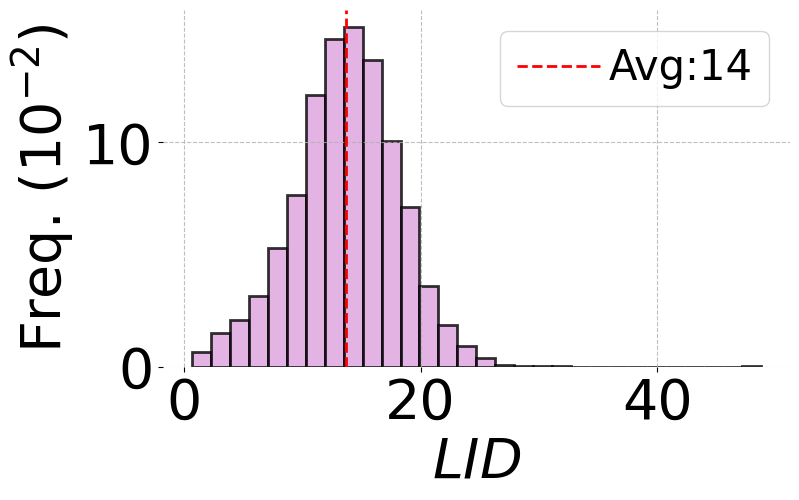

DEEP100M Average LID: 13.66


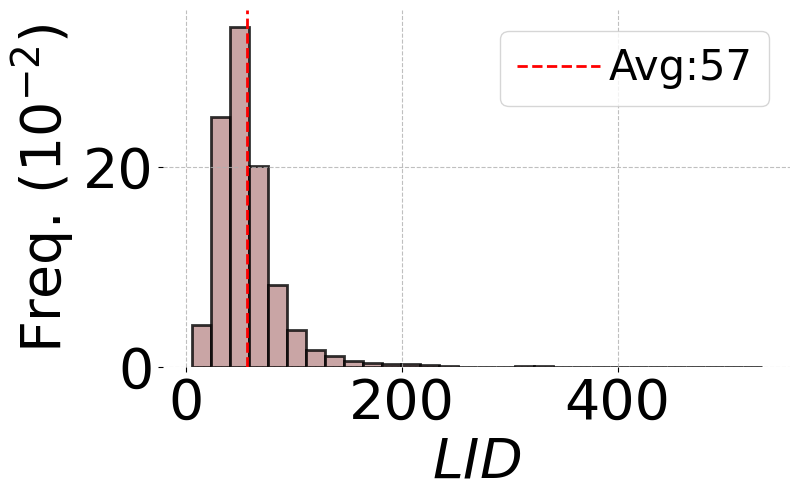

T2I100M Average LID: 56.85


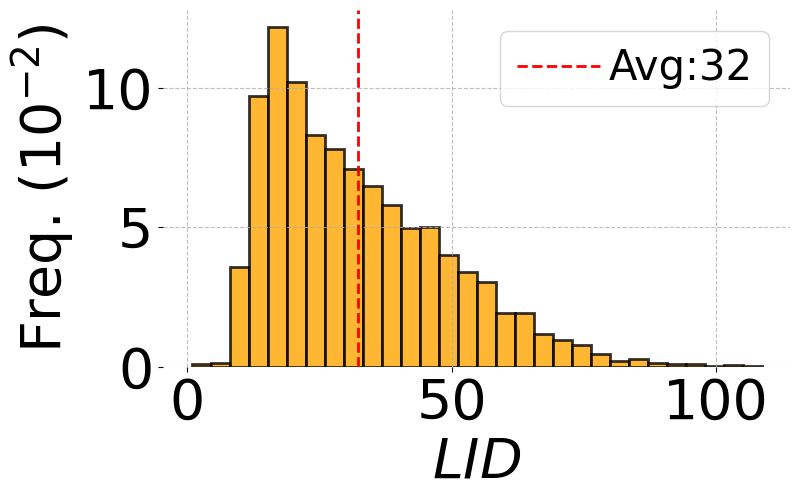

GLOVE100 Average LID: 32.24


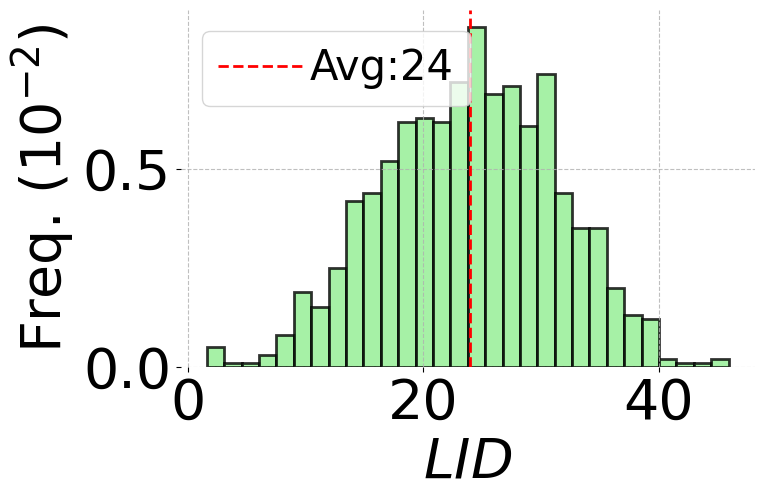

GIST1M Average LID: 23.96


In [5]:
all_datasets = ["SIFT100M", "DEEP100M", "T2I100M", "GLOVE100", "GIST1M"]
all_k = [100]

plt.rcParams.update({'font.size': 40})

for ds_name in all_datasets:
    ds_k_lids = []
    for k in all_k:
        query_gt_distances, _ = read_fvecs(dataset_params[ds_name]["queries_gt_distances_path"])
        queries, _ = read_fvecs(dataset_params[ds_name]["queries_path"])
        num_queries = queries.shape[0]
        
        all_gt_k = query_gt_distances.shape[1]
        all_lids = compute_lid_from_dists(query_gt_distances, all_gt_k, k, num_queries)
        
        lid_mean = np.mean(all_lids)
        ds_k_lids.append(lid_mean)
                
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        weights = np.ones_like(all_lids) / 100
        ax.hist(all_lids, bins=30, weights=weights, color=dataset_confs[ds_name]["color"], edgecolor='black', linewidth=2, alpha=0.8)
        ax.axvline(lid_mean, color='r', linestyle='dashed', linewidth=2, label=f"Avg:{lid_mean:.0f}")
        ax.set_xlabel(r"$LID$")
        p=r"$(10^{-2})$"
        ax.set_ylabel(f"Freq. {p}")
        ax.grid(alpha=0.8, linestyle='--')
        ax.legend(fontsize=30, labelspacing=0.2, handletextpad=0.2, )
        # Make legend font size smaller
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        fig.tight_layout()
        plt.savefig(f"./plots/lid_{ds_name}_k{k}.pdf", format='pdf', bbox_inches='tight')
        plt.show()
        plt.close()
        
    ds_lid = np.mean(ds_k_lids)
    print(f"{ds_name} Average LID: {ds_lid:.2f}")
        

## NN Distance Distributions

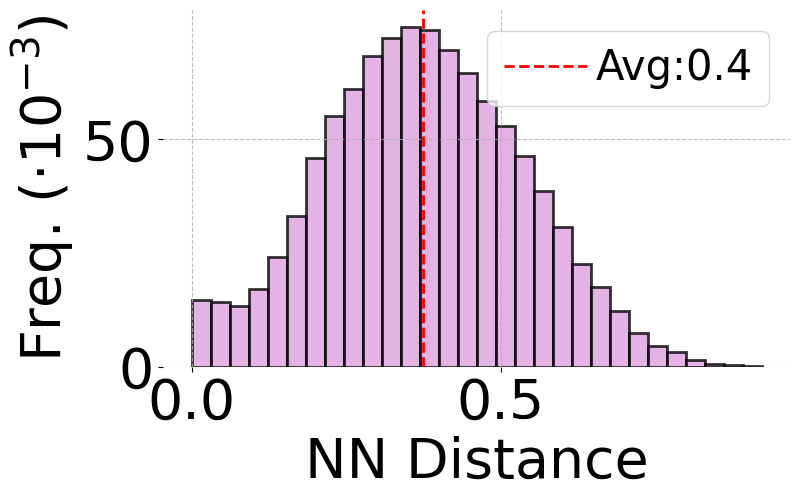

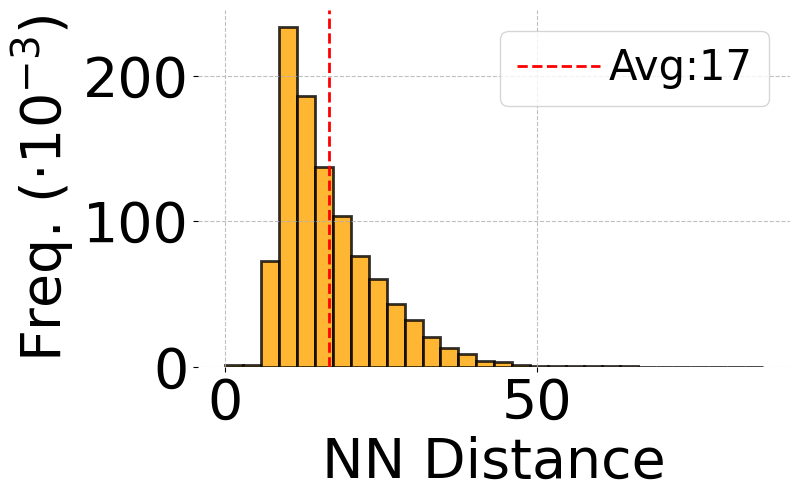

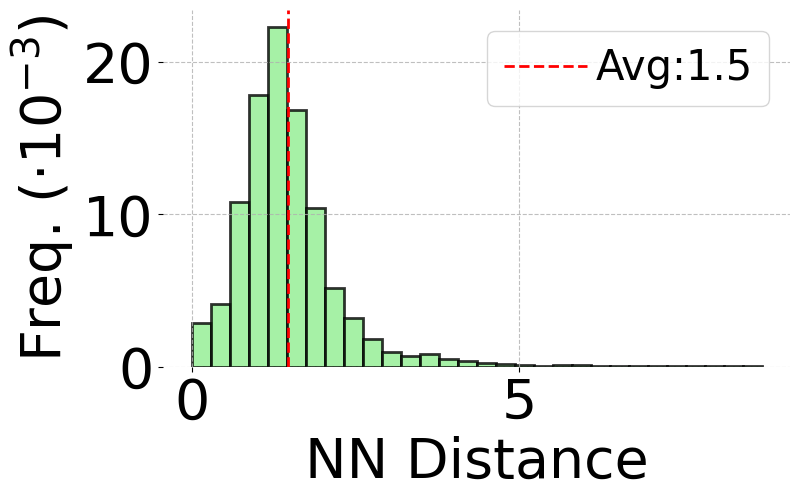

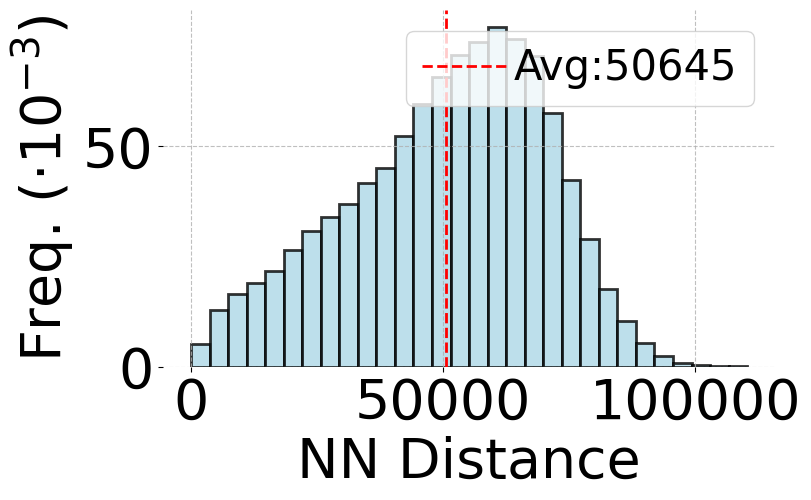

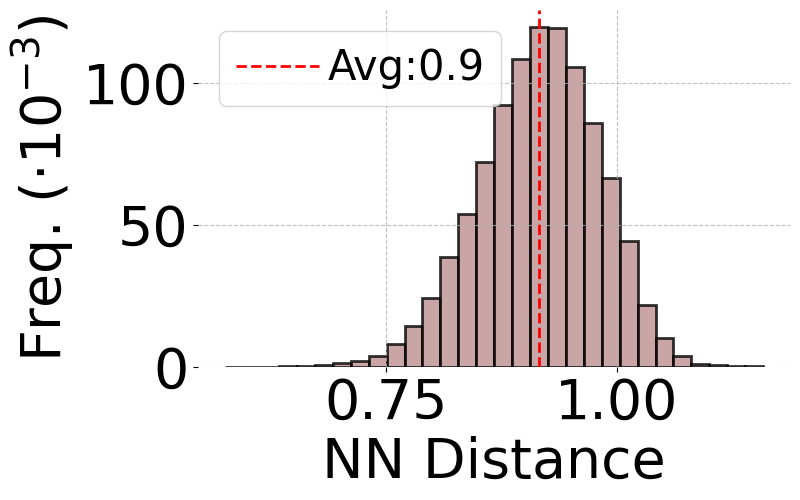

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 40})

all_datasets = ["DEEP100M", "GLOVE100", "GIST1M", "SIFT100M", "T2I100M"]

for ds_name in all_datasets:
    query_gt_distances, _ = read_fvecs(dataset_params[ds_name]["queries_gt_distances_path"])
    
    top_k_distances = query_gt_distances[:, :100].flatten()
    
    avg_dist = np.mean(top_k_distances)
    
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    
    weights = np.ones_like(top_k_distances) / 1000
    ax.hist(top_k_distances, bins=30, weights=weights, color=dataset_confs[ds_name]["color"], edgecolor='black', linewidth=2, alpha=0.8)
    label_str = f"Avg:{avg_dist:.1f}" if avg_dist < 10 else f"Avg:{avg_dist:.0f}"
    ax.axvline(avg_dist, color='r', linestyle='dashed', linewidth=2, label=label_str)
    
    ax.set_xlabel("NN Distance")
    p = r"$(\cdot10^{-3})$"
    ax.set_ylabel(f"Freq. {p}")
    ax.legend(fontsize=30, labelspacing=0.2, handletextpad=0.2, )
    ax.grid(alpha=0.8, linestyle='--')

    for spine in ax.spines.values():
        spine.set_visible(False)
    
    fig.tight_layout()
    plt.savefig(f"./plots/distribution_{ds_name}.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

## Checking the gt result distances

In [13]:

all_datasets = ["DEEP100M"]
all_k = [100]

plt.rcParams.update({'font.size': 40})

for ds_name in all_datasets:
    ds_k_lids = []
    query_gt_distances, _ = read_fvecs(dataset_params[ds_name]["queries_gt_distances_path"])
    
    print(query_gt_distances.shape)
    
    num_queries = query_gt_distances.shape[0]
    num_nns = query_gt_distances.shape[1]
    
    # Count zero distances for each query
    zero_distances_per_query = np.sum(query_gt_distances == 0, axis=1)
    
    print(f"For dataset {ds_name}:")
    print(f"Total queries: {num_queries}")
    print(f"Total nearest neighbors per query: {num_nns}")
    
    for i, zero_count in enumerate(zero_distances_per_query):
        if zero_count > 0:
            print(f"Query {i + 1}: {zero_count} zero-distance nearest neighbors")

(10000, 1000)
For dataset SIFT100M:
Total queries: 10000
Total nearest neighbors per query: 1000
Query 681: 1 zero-distance nearest neighbors
Query 1386: 1 zero-distance nearest neighbors
